In [1]:
using Revise

In [2]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra,
    Printf
;


In [2159]:
?mean

search: mean mean! meanad meandir meanlogx meanform meanresponse mean_and_var



```
mean(itr)
```

Compute the mean of all elements in a collection.

!!! note
    If `itr` contains `NaN` or [`missing`](@ref) values, the result is also `NaN` or `missing` (`missing` takes precedence if array contains both). Use the [`skipmissing`](@ref) function to omit `missing` entries and compute the mean of non-missing values.


# Examples

```jldoctest
julia> using Statistics

julia> mean(1:20)
10.5

julia> mean([1, missing, 3])
missing

julia> mean(skipmissing([1, missing, 3]))
2.0
```

---

```
mean(f, itr)
```

Apply the function `f` to each element of collection `itr` and take the mean.

```jldoctest
julia> using Statistics

julia> mean(√, [1, 2, 3])
1.3820881233139908

julia> mean([√1, √2, √3])
1.3820881233139908
```

---

```
mean(f, A::AbstractArray; dims)
```

Apply the function `f` to each element of array `A` and take the mean over dimensions `dims`.

!!! compat "Julia 1.3"
    This method requires at least Julia 1.3.


```jldoctest
julia> using Statistics

julia> mean(√, [1, 2, 3])
1.3820881233139908

julia> mean([√1, √2, √3])
1.3820881233139908

julia> mean(√, [1 2 3; 4 5 6], dims=2)
2×1 Matrix{Float64}:
 1.3820881233139908
 2.2285192400943226
```

---

```
mean(A::AbstractArray; dims)
```

Compute the mean of an array over the given dimensions.

!!! compat "Julia 1.1"
    `mean` for empty arrays requires at least Julia 1.1.


# Examples

```jldoctest
julia> using Statistics

julia> A = [1 2; 3 4]
2×2 Matrix{Int64}:
 1  2
 3  4

julia> mean(A, dims=1)
1×2 Matrix{Float64}:
 2.0  3.0

julia> mean(A, dims=2)
2×1 Matrix{Float64}:
 1.5
 3.5
```

---

```
mean(A::AbstractArray, w::AbstractWeights[, dims::Int])
```

Compute the weighted mean of array `A` with weight vector `w` (of type `AbstractWeights`). If `dim` is provided, compute the weighted mean along dimension `dims`.

# Examples

```julia
n = 20
x = rand(n)
w = rand(n)
mean(x, weights(w))
```

---

```
mean(d::UnivariateDistribution)
```

Compute the expectation.

---

```
mean(d::MultivariateDistribution)
```

Compute the mean vector of distribution `d`.

---

```
mean(d::MatrixDistribution)
```

Return the mean matrix of `d`.

---

```
mean(d::Union{UnivariateMixture, MultivariateMixture})
```

Compute the overall mean (expectation).


In [3]:
const λ = 626e-9
const Γ = 2π* 6.4e6
const m = @with_unit 57 "u"
const k = 2π / λ
_μB = (μ_B / h) * 1e-4
;

In [1450]:
function reorder_states!(H)
   states = H.states[:]
    i0 = 1
    for i in 1:1:length(H.states)
#         println(i)
#         display(H.states[i])
        if findmax(norm.(H.states[i].coeffs))[2] <= 3 
#             display(H.states[i])
            states[i0] = H.states[i]
            i0 += 1
        end
    end
    for i in 1:1:length(H.states)
#         println(i)
#         display(H.states[i])
        if findmax(norm.(H.states[i].coeffs))[2] >= 4 
#             display(H.states[i])
            states[i0] = H.states[i]
            i0 += 1
        end
    end
    H.states = states
end

function reorder_state_vector(old_states, proj_mapping)
    states = deepcopy(old_states)
    i0 = 1
    for i in 1:1:length(H.states)
        states[proj_mapping[i]] = old_states[i]
    end
    return states
end

reorder_state_vector (generic function with 2 methods)

# Markov Chain models

In [516]:
H_operator = :(
    T * L +
    B_z * Zeeman_L0
)
parameters = @params begin
    T = 1.0
    B_z = 5.0
end

# Create basis states
QN_bounds = (L = 0, N = 1)
ground_states = enumerate_states(AngularMomentumState_Labelled, QN_bounds)
QN_bounds = (L = 1, N = 1)
excited_states = enumerate_states(AngularMomentumState_Labelled, QN_bounds)

# Create Hamiltonian
basis = [ground_states; excited_states]
H = Hamiltonian(basis=basis, operator=H_operator, parameters=parameters)

H.parameters.B_z = 1.0*_μB
H.parameters.T = 20.0Γ
trap_det = -0Γ
# 
# TDM_x1(state, state′) = sum(arg * TDM(state, state′, q-2) + conj(arg * TDM(state′, state, q-2)) for (q,arg) ∈ enumerate(rotate_pol(σ⁺, +x̂)))
# TDM_x2(state, state′) = sum(arg * TDM(state, state′, q-2) + conj(arg * TDM(state′, state, q-2)) for (q,arg) ∈ enumerate(rotate_pol(σ⁺, -x̂)))
TDM_σ0(state, state′) = (TDM(state, state′, 0) + conj(TDM(state′, state, 0)))* Γ/2
H = add_to_H(H, :s, TDM_σ0)
H.parameters.s = 0.0

evaluate!(H)
QuantumStates.solve!(H)

reorder_states!(H)
update_basis_tdms!(H)
update_tdms!(H)
d = H.tdms
d_copy = d[:,:,:]
for j in 1:1:length(H.states)
   d[:, j, :] =  d[:, j, :]./ sqrt(sum(norm.(d_copy[:, j, 1]).^2) + sum(norm.(d_copy[:, j, 2]).^2) + sum(norm.(d_copy[:, j, 3]).^2)) 
end
d_bare = d[:,:,:]
bare_states = deepcopy(H.states)



H.parameters.s = sqrt(50/2) # this is sqrt(s/2)
evaluate!(H)
QuantumStates.solve!(H)

update_basis_tdms!(H)
update_tdms!(H)
d = H.tdms
d_copy = d[:,:,:]
for j in 1:1:length(H.states)
   d[:, j, :] =  d[:, j, :]./ sqrt(sum(norm.(d_copy[:, j, 1]).^2) + sum(norm.(d_copy[:, j, 2]).^2) + sum(norm.(d_copy[:, j, 3]).^2)) 
end
d_dressed = d[:,:,:]


;

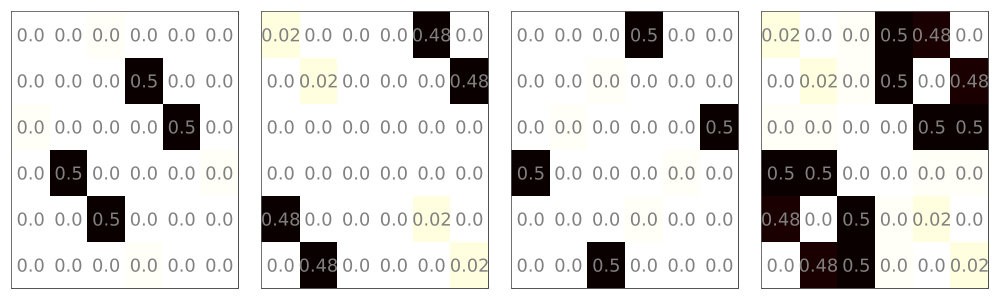

In [454]:
using Plots
tdms_squared = norm.(d_dressed[:,:,:]).^2

plot(
    size=(1000,300),
    box=:on,
    layout=(1,4)
    )
heatmap!(tdms_squared[:,:,1], c=cgrad(:hot, rev=true), legend=:none, yflip=true, subplot=1, ticks=nothing, colorbar=nothing)
heatmap!(tdms_squared[:,:,2], c=cgrad(:hot, rev=true), legend=:none, yflip=true, subplot=2, ticks=nothing, colorbar=nothing)
heatmap!(tdms_squared[:,:,3], c=cgrad(:hot, rev=true), legend=:none, yflip=true, subplot=3, ticks=nothing, colorbar=nothing)
heatmap!(sum(tdms_squared, dims=3)[:,:,1], c=cgrad(:hot, rev=true), legend=:none, yflip=true, subplot=4, ticks=nothing, colorbar=nothing)

nrow, ncol = size(tdms_squared[:,:,1])
ann = [(j,i, text(round(tdms_squared[i,j,1], digits=2), 12, :grey, :center)) for i in 1:nrow for j in 1:ncol]
annotate!(ann, linecolor=:white, subplot=1)

nrow, ncol = size(tdms_squared[:,:,1])
ann = [(j,i, text(round(tdms_squared[i,j,2], digits=2), 12, :grey, :center)) for i in 1:nrow for j in 1:ncol]
annotate!(ann, linecolor=:white, subplot=2)

nrow, ncol = size(tdms_squared[:,:,1])
ann = [(j,i, text(round(tdms_squared[i,j,3], digits=2), 12, :grey, :center)) for i in 1:nrow for j in 1:ncol]
annotate!(ann, linecolor=:white, subplot=3)

nrow, ncol = size(tdms_squared[:,:,1])
ann = [(j,i, text(round(sum(tdms_squared, dims=3)[i,j,1], digits=2), 12, :grey, :center)) for i in 1:nrow for j in 1:ncol]
annotate!(ann, linecolor=:white, subplot=4)

In [494]:
using StatsBase

s = 5.0 #saturation parameter

# detuning and saturation factor
det_factor = ([1+4*(energy(bare_states[j]) - energy(bare_states[i]) .+ trap_det)^2/Γ^2 for i ∈ 1:1:length(H.states), j ∈ 1:1:length(H.states)].^(-1)).*(s/2)

laser1_rate = ((norm.(d_bare[:,:,1])).^2).*det_factor

laser2_rate = ((norm.(d_bare[:,:,3])).^2).*det_factor

spontaneous_rate = sum(((norm.(d_bare)).^2), dims=(3))
    
transition_rates = [Weights([laser1_rate[i,:]; laser2_rate[i,:]; spontaneous_rate[i,:].*sum(norm.(bare_states[i].coeffs[4:6]).^2)]) for i ∈ 1:length(H.states)]

tdms_squared_det = tdms_squared[:,:,:]
tdms_squared_det[:,:,1] = tdms_squared[:,:,1] .* det_factor
tdms_squared_det[:,:,2] = tdms_squared[:,:,2] .* det_factor
tdms_squared_det[:,:,3] = tdms_squared[:,:,3] .* det_factor


# rates_i_wvs = [Weights(vec(tdms_squared_det[i,:,:])) for i ∈ 1:length(H.states)]
# rates_j_wvs = [Weights(vec(tdms_squared[:,j,:])) for j ∈ 1:length(H.states)]
cart_indices = CartesianIndices(tdms_squared[1,:,:])
decomposition_weights = [Weights(norm.(H.states[i].coeffs).^2) for i ∈ 1:length(H.states)];

for i in 1:1:length(H.states)
    d_dressed[i,i,:].=0
end
det_factor_dressed = ([1+4*(energy(H.states[j]) - energy(H.states[i]).+ trap_det)^2/Γ^2 for i ∈ 1:1:length(H.states), j ∈ 1:1:length(H.states)].^(-1)).*(s/2)

laser1_rate_dressed = ((norm.(d_dressed[:,:,1])).^2).*det_factor_dressed

laser2_rate_dressed = ((norm.(d_dressed[:,:,3])).^2).*det_factor_dressed

spontaneous_rate_dressed = sum(((norm.(d_dressed)).^2), dims=(3))
    
transition_rates_dressed = [Weights([laser1_rate_dressed[i,:]; laser2_rate_dressed[i,:]; spontaneous_rate_dressed[i,:].*sum(norm.(H.states[i].coeffs[4:6]).^2)]) for i ∈ 1:length(H.states)]
;

In [499]:
basis_overlap = zeros(Float64, length(H.states),length(H.states))
for j in 1:length(H.states)
    # j: dressed state index
    basis_overlap[:,j] = norm.(H.states[j].coeffs).^2 
end

collapse!(state, basis_overlap) = sample(Weights(basis_overlap[:,state]))
    
remix!(state, basis_overlap) = sample(Weights(basis_overlap[state,:]))
        
transition!(state, rates_weight) = sample(rates_weight[state])
# scatter_photon!(state, rates_i_wvs, cart_indices) = cart_indices[sample(rates_i_wvs[state])]
# decay!(state, rates_j_wvs, cart_indices) = cart_indices[sample(rates_j_wvs[state])]
;

In [1561]:

# n = 100
# current_state = 2
# prev_state = 2
# trap_scatters = 0
# antitrap_scatters = 0
# header = "================================================="
# for i ∈ 1:n
#     println(header)
#     @printf("dressed state %i", current_state)
#     println()
#     prev_state = current_state
#     current_state = transition!(current_state, transition_rates_dressed)
#     path = (current_state-1) ÷ length(H.states)
#     current_state = current_state % length(H.states)
#     if current_state == 0
#         current_state = length(H.states)
#     end
#     @printf("transition to %i", current_state)

#     if path == 0 # transition induced by laser 1
#         eg = sample(decomposition_weights[current_state])
#         if eg <= 3
#             trap_scatters -= 1 # final state is ground --- stimulated emission
#             print(" via stimulated emission (laser 1)")
#         else
#             trap_scatters += 1 # final state is excited --- absorption
#             print(" via absorption (laser 1)")
#         end
#     elseif path == 1 # transition induced by laser 2
#         eg = sample(decomposition_weights[current_state])
#         if eg <= 3
#             antitrap_scatters -= 1
#             print(" via stimulated emission (laser 2)")
#         else
#             antitrap_scatters += 1
#             print(" via absorption (laser 2)")
#         end
#     else
#         print(" via spontaneous emission")
#     end
#     println()

# end


In [1562]:
# n = 50
# current_state = 2
# prev_state = 2
# trap_scatters = 0
# antitrap_scatters = 0
# header = "==================================================================="
# for i ∈ 1:n
#     println(header)
#     @printf("dressed state %i", current_state)
#     println()
#     # current_state here is a dressed state
    
#     current_state = collapse!(current_state, basis_overlap) # collapse to a bare state
#     @printf("collapsed to bare state %i", current_state)
#     println()
#     current_state = transition!(current_state, transition_rates) # transition to another bare state
#     path = (current_state-1) ÷ length(H.states)
#     current_state = current_state % length(H.states)
#     if current_state == 0
#         current_state = length(H.states)
#     end
#     @printf("transitioned to bare state %i", current_state)

#     if path == 0 # transition induced by laser 1
#         if current_state <= 3
#             trap_scatters -= 1 # final state is ground --- stimulated emission
#             println(" via stimulated emission (laser 1)")
#         else
#             trap_scatters += 1 # final state is excited --- absorption
#             println(" via absorption (laser 1)")
#         end
#     elseif path == 1 # transition induced by laser 2
#         if current_state <= 3
#             antitrap_scatters -= 1
#             println(" via stimulated emission (laser 2)")
#         else
#             antitrap_scatters += 1
#             println(" via absorption (laser 2)")
#         end
#     else
#         println(" via spontaneous emission")
#     end

#     current_state = remix!(current_state, basis_overlap) # remixed by orthogonal beam
#     @printf("remixed into dressed state %i", current_state)
#     println()
# end

 36.364619 seconds (739.48 M allocations: 33.371 GiB, 15.61% gc time)
-0.13520000000062282


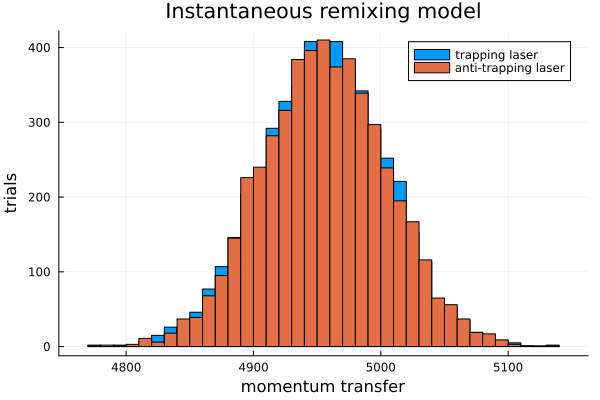

In [508]:
# Instantaneous remixing model
n_trap = []
n_antitrap = []


@time for nn in 1:1:5000
    n = 20000
    current_state = sample(init_states)
    prev_state = current_state
    trap_scatters = 0
    antitrap_scatters = 0
    for i ∈ 1:n
        # current_state here is a dressed state
        current_state = collapse!(current_state, basis_overlap) # collapse to a bare state
        
        current_state = transition!(current_state, transition_rates) # transition to another bare state
        path = (current_state-1) ÷ length(H.states)
        current_state = current_state % length(H.states)
        if current_state == 0
            current_state = length(H.states)
        end
        
        if path == 0 # transition induced by laser 1
            if current_state <= 3
                trap_scatters -= 1 # final state is ground --- stimulated emission
            else
                trap_scatters += 1 # final state is excited --- absorption
            end
        elseif path == 1 # transition induced by laser 2
            if current_state <= 3
                antitrap_scatters -= 1
            else
                antitrap_scatters += 1
            end
        end
        
        current_state = remix!(current_state, basis_overlap) # remixed by orthogonal beam
        
    end
    push!(n_trap, trap_scatters)
    push!(n_antitrap, antitrap_scatters)
end
println(mean(n_trap) - mean(n_antitrap))
barhist(n_trap, label="trapping laser")
barhist!(n_antitrap, label="anti-trapping laser",xlabel="momentum transfer",ylabel="trials")
title!("Instantaneous remixing model")

  2.249014 seconds (33.26 M allocations: 660.145 MiB, 5.54% gc time)
222.61400000000003


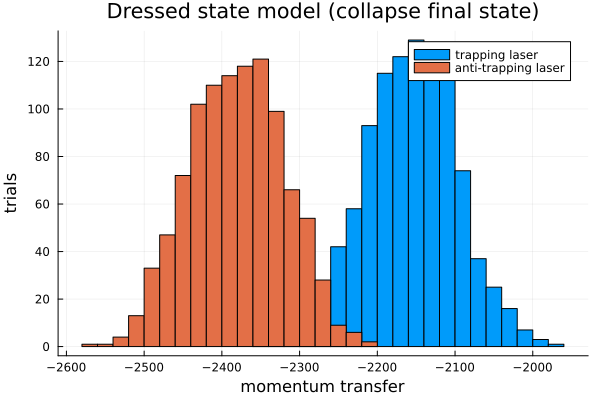

In [509]:
n_trap = []
n_antitrap = []


@time for nn in 1:1:1000
    n = 10000
    current_state = 2
    prev_state = 2
    trap_scatters = 0
    antitrap_scatters = 0
    for i ∈ 1:n
        prev_state = current_state
        current_state = transition!(current_state, transition_rates_dressed)
        path = (current_state-1) ÷ length(H.states)
        current_state = current_state % length(H.states)
        if current_state == 0
            current_state = length(H.states)
        end
        
        if path == 0 # transition induced by laser 1
            eg = sample(decomposition_weights[current_state])
            if eg == 1 || eg == 2 || eg == 3
                trap_scatters -= 1 # final state is ground --- stimulated emission
            else
                trap_scatters += 1 # final state is excited --- absorption
            end
        elseif path == 1 # transition induced by laser 2
            eg = sample(decomposition_weights[current_state])
            if eg == 1 || eg == 2 || eg == 3
                antitrap_scatters -= 1
            else
                antitrap_scatters += 1
            end
        end
        
    end
    push!(n_trap, trap_scatters)
    push!(n_antitrap, antitrap_scatters)
end
println(mean(n_trap) - mean(n_antitrap))
barhist(n_trap, label="trapping laser")
barhist!(n_antitrap, label="anti-trapping laser",xlabel="momentum transfer",ylabel="trials")
title!("Dressed state model (collapse final state)")

 11.267460 seconds (167.32 M allocations: 3.239 GiB, 5.70% gc time)
-218.51799999999957


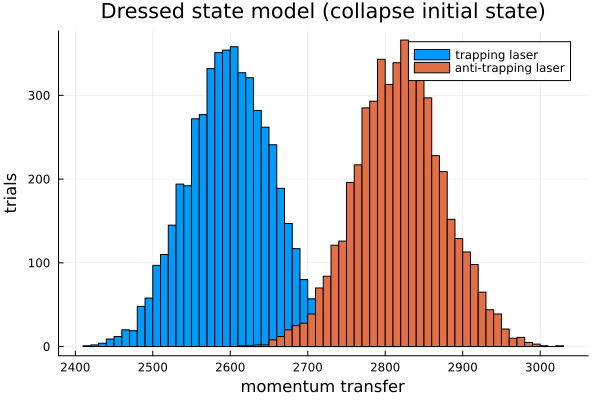

In [510]:
n_trap = []
n_antitrap = []


@time for nn in 1:1:5000
    n = 10000
    current_state = 2
    prev_state = 2
    trap_scatters = 0
    antitrap_scatters = 0
    for i ∈ 1:n
        prev_state = current_state
        current_state = transition!(current_state, transition_rates_dressed)
        path = (current_state-1) ÷ length(H.states)
        current_state = current_state % length(H.states)
        if current_state == 0
            current_state = length(H.states)
        end
        
        if path == 0 # transition induced by laser 1
            eg = sample(decomposition_weights[prev_state])
            if eg == 1 || eg == 2 || eg == 3
                trap_scatters += 1 # initial state is ground --- absorption
            else
                trap_scatters -= 1 # initial state is excited --- stimulated emission
            end
        elseif path == 1 # transition induced by laser 2
            eg = sample(decomposition_weights[prev_state])
            if eg == 1 || eg == 2 || eg == 3
                antitrap_scatters += 1
            else
                antitrap_scatters -= 1
            end
        end
        
    end
    push!(n_trap, trap_scatters)
    push!(n_antitrap, antitrap_scatters)
end

println(mean(n_trap) - mean(n_antitrap))
barhist(n_trap, label="trapping laser")
barhist!(n_antitrap, label="anti-trapping laser",xlabel="momentum transfer",ylabel="trials")
title!("Dressed state model (collapse initial state)")

158.616892 seconds (2.01 G allocations: 37.386 GiB, 4.98% gc time)
11.35319999999956


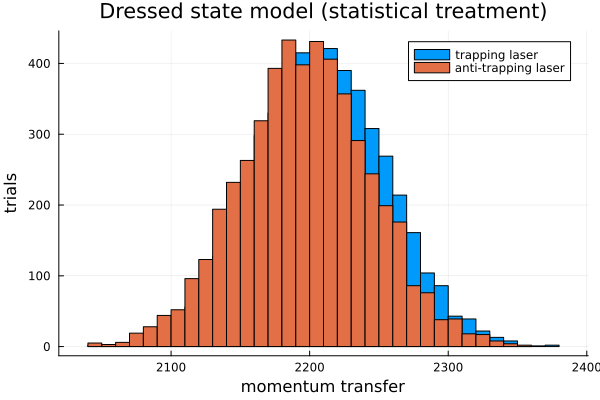

In [511]:
n_trap = []
n_antitrap = []
state_counter = zeros(length(H.states))

@time for nn in 1:1:5000
    n = 100000
    current_state = 2
    prev_state = 2
    trap_scatters = 0
    antitrap_scatters = 0
    for i ∈ 1:n
        prev_state = current_state
        current_state = transition!(current_state, transition_rates_dressed)
        path = (current_state-1) ÷ length(H.states)
        current_state = current_state % length(H.states)
        if current_state == 0
            current_state = length(H.states)
        end
        
        if path == 0 # transition induced by laser 1
            eg1 = sample(decomposition_weights[prev_state])
            eg2 = sample(decomposition_weights[current_state])
            if eg1 <= 3 && eg2 > 3
                trap_scatters += 1 # ground to excited --- absorption
                state_counter[current_state] += 1
            elseif eg1 > 3 && eg2 <= 3
                trap_scatters -= 1 # excited to ground --- stimulated emission
                state_counter[current_state] += 1
            end
        elseif path == 1 # transition induced by laser 2
            eg1 = sample(decomposition_weights[prev_state])
            eg2 = sample(decomposition_weights[current_state])
            if eg1 <= 3 && eg2 > 3
                antitrap_scatters += 1
                state_counter[current_state] += 1
            elseif eg1 > 3 && eg2 <= 3
                antitrap_scatters -= 1
                state_counter[current_state] += 1
            end
        else
            state_counter[current_state] += 1
        end
        
    end
    push!(n_trap, trap_scatters)
    push!(n_antitrap, antitrap_scatters)
end

println(mean(n_trap) - mean(n_antitrap))
barhist(n_trap, label="trapping laser")
barhist!(n_antitrap, label="anti-trapping laser",xlabel="momentum transfer",ylabel="trials")
title!("Dressed state model (statistical treatment)")

# Effective Zeeman Shifts

In [1653]:
Δ_orthog = 20.0Γ
s_orthog = 50.0

H_operator = :(
    T * L +
    B_z * Zeeman_L0
)
parameters = @params begin
    T = 1.0
    B_z = 5.0
end

# Create basis states
QN_bounds = (L = 0, N = 1)
ground_states = enumerate_states(AngularMomentumState_Labelled, QN_bounds)
QN_bounds = (L = 1, N = 1)
excited_states = enumerate_states(AngularMomentumState_Labelled, QN_bounds)

# Create Hamiltonian
basis = [ground_states; excited_states]
H = Hamiltonian(basis=basis, operator=H_operator, parameters=parameters)

H.parameters.B_z = 0.0*_μB
H.parameters.T = -Δ_orthog
# 
# TDM_x1(state, state′) = sum(arg * TDM(state, state′, q-2) + conj(arg * TDM(state′, state, q-2)) for (q,arg) ∈ enumerate(rotate_pol(σ⁺, +x̂)))
# TDM_x2(state, state′) = sum(arg * TDM(state, state′, q-2) + conj(arg * TDM(state′, state, q-2)) for (q,arg) ∈ enumerate(rotate_pol(σ⁺, -x̂)))
TDM_σ0(state, state′) = (TDM(state, state′, 0) + conj(TDM(state′, state, 0)))* Γ/2
H = add_to_H(H, :s, TDM_σ0)
H.parameters.s = sqrt(s_orthog/2) # this is sqrt(s/2)
evaluate!(H)
QuantumStates.solve!(H)

update_basis_tdms!(H)
update_tdms!(H)
d = H.tdms
d_copy = d[:,:,:]
for j in 1:1:length(H.states)
   d[:, j, :] =  d[:, j, :]./ sqrt(sum(norm.(d_copy[:, j, 1]).^2) + sum(norm.(d_copy[:, j, 2]).^2) + sum(norm.(d_copy[:, j, 3]).^2)) 
end
d_dressed = d[:,:,:]

B_scan = collect(LinRange(0,200,41)).*_μB
energies = zeros((length(B_scan),6))
    
for i in 1:1:length(B_scan)
    H.parameters.B_z = B_scan[i]
    evaluate!(H)
    QuantumStates.solve!(H)
    energies[i,:] = [energy(H.states[j]) for j in 1:1:6]
end

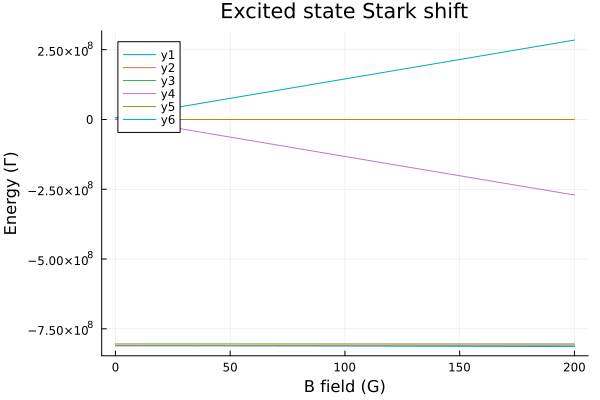

In [1654]:
plot(B_scan./_μB, energies[:,1].+(0Γ))
plot!(B_scan./_μB, energies[:,2].+(0Γ))
plot!(B_scan./_μB, energies[:,3].+(0Γ))
plot!(B_scan./_μB, energies[:,4])
plot!(B_scan./_μB, energies[:,5])
plot!(B_scan./_μB, energies[:,6])
plot!(xlabel="B field (G)", ylabel="Energy (Γ)", title="Excited state Stark shift")

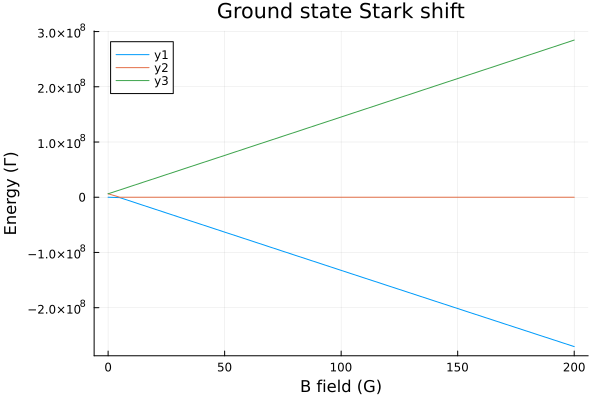

In [1655]:

plot(B_scan./_μB, energies[:,4])
plot!(B_scan./_μB, energies[:,5])
plot!(B_scan./_μB, energies[:,6])
plot!(xlabel="B field (G)", ylabel="Energy (Γ)", title="Ground state Stark shift")

In [1658]:
h

6.62607015e-34

In [1659]:
_μB * 

3.02987330914053e-34

In [2052]:
Δ_orthog = 20.0Γ
s_orthog = 50.0

H_operator = :(
    T * L +
    B_z * Zeeman_L0
)
parameters = @params begin
    T = 1.0
    B_z = 5.0
end

# Create basis states
QN_bounds = (L = 0, N = 1)
ground_states = enumerate_states(AngularMomentumState_Labelled, QN_bounds)
QN_bounds = (L = 1, N = 1)
excited_states = enumerate_states(AngularMomentumState_Labelled, QN_bounds)

# Create Hamiltonian
basis = [ground_states; excited_states]
H = Hamiltonian(basis=basis, operator=H_operator, parameters=parameters)

H.parameters.B_z = 0.0*_μB
H.parameters.T = -Δ_orthog
trap_det = -0Γ
# 
# TDM_x1(state, state′) = sum(arg * TDM(state, state′, q-2) + conj(arg * TDM(state′, state, q-2)) for (q,arg) ∈ enumerate(rotate_pol(σ⁺, +x̂)))
# TDM_x2(state, state′) = sum(arg * TDM(state, state′, q-2) + conj(arg * TDM(state′, state, q-2)) for (q,arg) ∈ enumerate(rotate_pol(σ⁺, -x̂)))
TDM_σ0(state, state′) = (TDM(state, state′, 0) + conj(TDM(state′, state, 0)))* Γ/2
H = add_to_H(H, :s, TDM_σ0)

H.parameters.s = 0.0
H.parameters.B_z = 0.0
H.parameters.T = 1e12

evaluate!(H)
QuantumStates.solve!(H)

reorder_states!(H)
update_basis_tdms!(H)
update_tdms!(H)
d = H.tdms
d_copy = d[:,:,:]
for j in 1:1:length(H.states)
   d[:, j, :] =  d[:, j, :]./ sqrt(sum(norm.(d_copy[:, j, 1]).^2) + sum(norm.(d_copy[:, j, 2]).^2) + sum(norm.(d_copy[:, j, 3]).^2)) 
end
d_bare = deepcopy(d)
bare_states = deepcopy(H.states)
;

# Laser parameters

Δ = 5.0Γ
s = 10.0

# Frequency of the lasers (in angular frequency units)
ω1 = 2π * (energy(H.states[end]) - energy(H.states[1])) + Δ
ω2 = 2π * (energy(H.states[end]) - energy(H.states[1])) + Δ_orthog

ϵ_(ϵ1) = t -> ϵ1

k̂ = +x̂; ϵ1 = ϵ_( -im .* rotate_pol(σ⁺, k̂)); laser1 = Field(k̂, ϵ1, ω1, s)
k̂ = -x̂; ϵ2 = ϵ_( -im .* rotate_pol(σ⁺, k̂)); laser2 = Field(k̂, ϵ2, ω1, s)
k̂ = +ŷ; ϵ3 = ϵ_( -rotate_pol(σ⁺, k̂)); laser3 = Field(k̂, ϵ3, ω1, s)
k̂ = -ŷ; ϵ4 = ϵ_( -rotate_pol(σ⁺, k̂)); laser4 = Field(k̂, ϵ4, ω1, s)
k̂ = +ẑ; ϵ5 = ϵ_( rotate_pol(σ⁺, k̂)); laser5 = Field(k̂, ϵ5, ω1, s)
k̂ = -ẑ; ϵ6 = ϵ_( rotate_pol(σ⁺, k̂)); laser6 = Field(k̂, ϵ6, ω1, s)

k̂ = +x̂; ϵ1 = ϵ_(σ⁰); laser1_orthog = Field(k̂, ϵ1, ω2, s_orthog)
k̂ = -x̂; ϵ2 = ϵ_(σ⁰); laser2_orthog = Field(k̂, ϵ2, ω2, s_orthog)

lasers = [laser1_orthog, laser2_orthog, laser5, laser6]
;

H.parameters.B_z = 12.0*_μB
H.parameters.T = 1e12

evaluate!(H)
QuantumStates.solve!(H)
;

In [2053]:
particle = Particle()
ρ0 = zeros(ComplexF64, length(H.states), length(H.states))
ρ0[1,1] = 1.0
freq_res = 1e-1

p = obe(ρ0, particle, H.states, lasers, d, d, true, true, λ, Γ, freq_res, nothing)

t_end = 10p.period
tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p)
;

In [2054]:
callback = PeriodicCallback(reset_force!, prob.p.period)

prob.p.r0 = (0., 0., 0.3) .* 2π
prob.p.v = (0., 0., 0.)
@time sol = DifferentialEquations.solve(prob, alg=DP5(), reltol=1e-3, callback=callback)
prob.p.force_last_period .* 1e3

  2.292514 seconds (4.31 M allocations: 290.143 MiB, 8.02% gc time, 99.25% compilation time)


3-element SVector{3, Float64} with indices SOneTo(3):
  0.0
  0.0
 -2.9514685525657995

In [2055]:
# prob.p.populations

In [2056]:
# using Plots
# plot_us = sol.u#[1:10:end]
# plot_ts = sol.t#[1:10:end]

# n_states = size(p.ρ_soa, 1)
# plot(size=(800, 400), ylim=(-0.1, 1.1), legend=nothing)
# for i in 1:n_states
#     state_idx = n_states*(i-1) + i
#     plot!(plot_ts, [real(u[state_idx]) for u in plot_us])
# end
# plot!()
# offset = 0
# vline!([sol.t[end] - prob.p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)

In [2057]:
# plot(size=(800, 400), legend=nothing)
# plot!(plot_ts, 1e3 .* [real(u[end-2]) for u in plot_us] ./ prob.p.period)
# plot!(plot_ts, 1e3 .* [real(u[end-1]) for u in plot_us] ./ prob.p.period)
# plot!(plot_ts, 1e3 .* [real(u[end]) for u in plot_us] ./ prob.p.period)
# plot!()
# offset = 0
# vline!([sol.t[end] - prob.p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)

In [2058]:
using Distributions
uniform_dist = Uniform(0, 2π)
function sample_direction(r=1.0)
    θ = 2π * rand()
    z = rand() * 2 - 1
    return (r * sqrt(1 - z^2) * cos(θ), r * sqrt(1 - z^2) * sin(θ), r * z)
end
;

## Force versus magnetic field

In [2059]:
function prob_func!(prob, scan_params, i)
    p = prob.p
    
    # Update velocity and position
    p.particle.v .= scan_params[i].v
    p.particle.r0 .= scan_params[i].r
    
    # Update magnetic field
    H = p.extra_p.H
    H.parameters.B_z = scan_params[i].B
    evaluate!(H)
    QuantumStates.solve!(H)
    
    # Update transition dipole moments
    update_basis_tdms!(H)
    update_tdms!(H)
    new_d = H.tdms
    
    new_p = obe(p.ρ0, p.particle, H.states, p.extra_p.lasers, new_d, nothing, true, true, p.λ, p.Γ, p.freq_res, p.extra_p)
    
    return remake(prob, p=new_p)
end
function output_func(p, sol)
    f = p.force_last_period
    return f
end
;

In [2060]:
using RectiGrids

freq_res = 1e-1
extra_p = (H=H, lasers=lasers)
p = obe(ρ0, particle, H.states, lasers, d, d, true, true, λ, Γ, freq_res, extra_p)

t_end = 10p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, reltol=1e-3, save_on=false)

Bs = (0:1.0:30.0).*_μB
di = 5
rs = vcat([(n1*λ/(di+1), n2*λ/(di+1), n3*λ/(di+1)) .* 2π for n1 ∈ 0:di, n2 ∈ 0:di, n3 ∈ 0:di]...)
vs = [sample_direction(0.0) for _ in 1:1]

Bs = collect(LinRange(0,200,81)).*_μB
scan_values_grid = RectiGrids.grid(scan_values)
;

In [2061]:
@time forces, populations = force_scan_v2(prob, scan_values_grid, prob_func!, output_func);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.715497 seconds (4.76 M allocations: 311.427 MiB, 3.62% gc time, 1739.89% compilation time)


In [2062]:
averaged_forces = []
@time for (i,B) ∈ enumerate(Bs)
    idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.B == B]
    push!(averaged_forces, mean([f[3] for f in forces[idxs]]))
end

  0.074233 seconds (73.88 k allocations: 4.864 MiB, 97.35% compilation time)


In [2063]:
averaged_populations = []
@time for (i,B) ∈ enumerate(Bs)
    idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.B == B]
    push!(averaged_populations, mean([p for p in populations[idxs,:]], dims=1))
end

  0.056365 seconds (49.14 k allocations: 3.225 MiB, 97.75% compilation time)


In [2064]:
λ_ = 626e-9
Γ_ = 2π * 6.4e6 # in units of MHz
m_ = @with_unit 57 "u"
k_ = 2π / λ_

1.0037037231916271e7

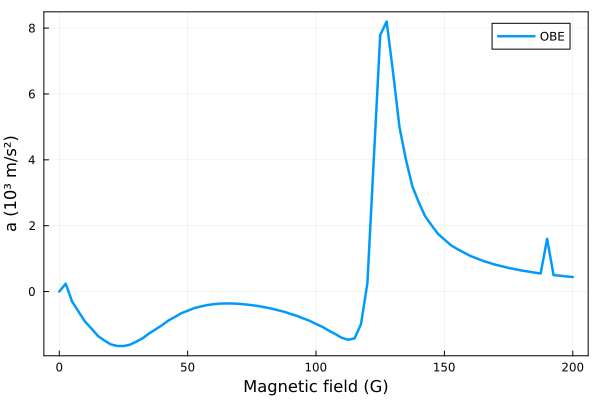

In [2019]:
plot(Bs./_μB, 1e-3 .* averaged_forces .* (ħ * k * Γ / m),
    xlabel="Magnetic field (G)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    label="OBE"
    # labelfontsize=14,
    # tickfont=12,
    # legendfont=11,
    # ylim=(-3,23),
    # size=(600,500)
    )

# Rate Equation

In [1878]:
function prob_func_re!(prob, scan_params, i)
    p = prob.p
    
    # Update velocity and position
    p.particle.v[3] = scan_params[i].v
    p.particle.r0 .= scan_params[i].r
    new_p = remake_rate_equation_B(p, scan_params[i].B)
    return remake(prob, p=new_p)
end
;

In [2147]:
Δ_orthog = 30.0Γ
s_orthog = 50.0

H_operator = :(
    T * L +
    B_z * Zeeman_L0
)
parameters = @params begin
    T = 1.0
    B_z = 5.0
end

# Create basis states
QN_bounds = (L = 0, N = 1)
ground_states = enumerate_states(AngularMomentumState_Labelled, QN_bounds)
QN_bounds = (L = 1, N = 1)
excited_states = enumerate_states(AngularMomentumState_Labelled, QN_bounds)

# Create Hamiltonian
basis = [ground_states; excited_states]
H = Hamiltonian(basis=basis, operator=H_operator, parameters=parameters)

H.parameters.B_z = 0.0*_μB
H.parameters.T = -Δ_orthog
trap_det = -0Γ
# 
# TDM_x1(state, state′) = sum(arg * TDM(state, state′, q-2) + conj(arg * TDM(state′, state, q-2)) for (q,arg) ∈ enumerate(rotate_pol(σ⁺, +x̂)))
# TDM_x2(state, state′) = sum(arg * TDM(state, state′, q-2) + conj(arg * TDM(state′, state, q-2)) for (q,arg) ∈ enumerate(rotate_pol(σ⁺, -x̂)))
TDM_σ0(state, state′) = (TDM(state, state′, 0) + conj(TDM(state′, state, 0)))* Γ/2
H = add_to_H(H, :s, TDM_σ0)

H.parameters.s = 0.0
H.parameters.B_z = 0.0
H.parameters.T = 1e12

evaluate!(H)
QuantumStates.solve!(H)

reorder_states!(H)
update_basis_tdms!(H)
update_tdms!(H)
d = H.tdms
d_copy = d[:,:,:]
for j in 1:1:length(H.states)
   d[:, j, :] =  d[:, j, :]./ sqrt(sum(norm.(d_copy[:, j, 1]).^2) + sum(norm.(d_copy[:, j, 2]).^2) + sum(norm.(d_copy[:, j, 3]).^2)) 
end
d_bare = deepcopy(d)
bare_states = deepcopy(H.states)
;

# Laser parameters

Δ = 10.0Γ
s = 50.0

# Frequency of the lasers (in angular frequency units)
ω1 = 2π * (energy(H.states[end]) - energy(H.states[1])) + Δ
ω2 = 2π * (energy(H.states[end]) - energy(H.states[1])) + Δ_orthog

ϵ_(ϵ1) = t -> ϵ1

k̂ = +x̂; ϵ1 = ϵ_( -im .* rotate_pol(σ⁺, k̂)); laser1 = Field(k̂, ϵ1, ω2, s_orthog)
k̂ = -x̂; ϵ2 = ϵ_( -im .* rotate_pol(σ⁺, k̂)); laser2 = Field(k̂, ϵ2, ω2, s_orthog)
k̂ = +ŷ; ϵ3 = ϵ_( -rotate_pol(σ⁺, k̂)); laser3 = Field(k̂, ϵ3, ω2, s_orthog)
k̂ = -ŷ; ϵ4 = ϵ_( -rotate_pol(σ⁺, k̂)); laser4 = Field(k̂, ϵ4, ω2, s_orthog)
k̂ = +ẑ; ϵ5 = ϵ_( rotate_pol(σ⁺, k̂)); laser5 = Field(k̂, ϵ5, ω1, s)
k̂ = -ẑ; ϵ6 = ϵ_( rotate_pol(σ⁺, k̂)); laser6 = Field(k̂, ϵ6, ω1, s)

k̂ = +x̂; ϵ1 = ϵ_(σ⁰); laser1_orthog = Field(k̂, ϵ1, ω2, s_orthog)
k̂ = -x̂; ϵ2 = ϵ_(σ⁰); laser2_orthog = Field(k̂, ϵ2, ω2, s_orthog)

lasers = [laser1_orthog, laser2_orthog, laser5, laser6]#
# lasers = [laser1, laser2, laser3, laser4, laser5, laser6]
;

  1.607445 seconds (2.43 M allocations: 166.306 MiB, 7.70% gc time, 99.57% compilation time)
Force = -7.56e-01

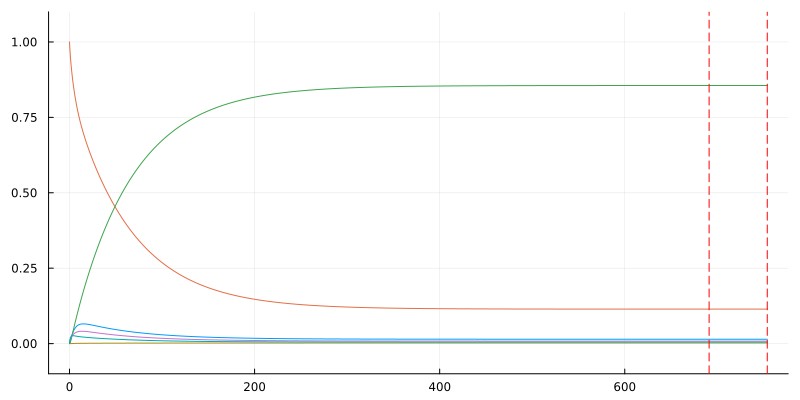

In [2148]:
N0 = [0,1.0,0,0,0,0]
freq_res = 1e-1
extra_p = MutableNamedTuple(H=deepcopy(H), lasers=lasers, n_ground=3, bare_states = deepcopy(bare_states), Δ_orthog=Δ_orthog, T=1e12, s_orthog=0.0)
particle.v = [0,0,0.0]

p = rate_equation(N0, particle, bare_states, lasers, d_bare, d_bare, true, true, λ, Γ, freq_res, extra_p)
p = remake_rate_equation_B(p, 125*_μB)

t_end = 20p.period+1; tspan = (0., t_end)
cb = PeriodicCallback(reset_force1!, p.period)

prob = ODEProblem(N!, p.N0_vec, tspan, p, reltol=1e-3, save_on=true)
@time sol = DifferentialEquations.solve(prob, alg=DP5(), reltol=1e-3, callback=cb)

@printf("Force = %.2e", p.force_last_period[3].* (ħ * k * Γ / m).*1e-3)

using Plots
plot_us = sol.u#[1:10:end]
plot_ts = sol.t#[1:10:end]

n_states = length(H.states)
plot(size=(800, 400), ylim=(-0.1, 1.1), legend=nothing)
for i in 1:n_states
    plot!(plot_ts, [real(u[i]) for u in plot_us])
end
plot!()
offset = 0
vline!([sol.t[end] - prob.p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)


In [2149]:
prob.p.populations

6-element Vector{Float64}:
 0.014528737691584604
 0.11430411397271362
 0.8557041888795754
 0.008390025732958207
 0.00204728328468229
 0.005025650438485956

In [2150]:
@printf("Force = %.2e", p.force_last_period[3].* (ħ * k * Γ / m).*1e-3)
println()

N = zeros(9);
N[1] = 1.0
dN = zeros(15)
N!(dN,N,prob.p, 0)
println("+z forces:")
println(dN[5]*(prob.p.populations[1] - prob.p.populations[5]))
N[2] = 1.0
dN = zeros(15)
N!(dN,N,prob.p, 0)
println(dN[6]*(prob.p.populations[2] - prob.p.populations[6]))
println()

N = zeros(9);
N[3] = 1.0
dN = zeros(15)
N!(dN,N,prob.p, 0)
println("-z forces:")
println(dN[5]*(prob.p.populations[3] - prob.p.populations[5]))
N[2] = 1.0
dN = zeros(15)
N!(dN,N,prob.p, 0)
println(dN[4]*(prob.p.populations[2] - prob.p.populations[4]))

Force = -7.56e-01
+z forces:
0.00013021481278501098
0.0034064358957053517

-z forces:
0.0019170687367849337
0.0033015613541070897


In [2151]:
prob.p.populations

6-element Vector{Float64}:
 0.014528737691584604
 0.11430411397271362
 0.8557041888795754
 0.008390025732958207
 0.00204728328468229
 0.005025650438485956

In [2152]:
@printf("Force = %.2e", p.force_last_period[3].* (ħ * k * Γ / m).*1e-3)
println()

N = zeros(9);
N[1] = 1.0
dN = zeros(15)
N!(dN,N,prob.p, 0)
println("+z forces:")
println(dN[5]*(prob.p.populations[1] - prob.p.populations[5]))
N[2] = 1.0
dN = zeros(15)
N!(dN,N,prob.p, 0)
println(dN[6]*(prob.p.populations[2] - prob.p.populations[6]))
println()

N = zeros(9);
N[3] = 1.0
dN = zeros(15)
N!(dN,N,prob.p, 0)
println("-z forces:")
println(dN[5]*(prob.p.populations[3] - prob.p.populations[5]))
N[2] = 1.0
dN = zeros(15)
N!(dN,N,prob.p, 0)
println(dN[4]*(prob.p.populations[2] - prob.p.populations[4]))

Force = -7.56e-01
+z forces:
0.00013021481278501098
0.0034064358957053517

-z forces:
0.0019170687367849337
0.0033015613541070897


In [2153]:
N = zeros(9);
N[1] = 1.0
dN = zeros(15)
N!(dN,N,prob.p, 0)
dN

15-element Vector{Float64}:
 -0.8393451302538444
  0.0
  0.0
  0.8289124668365906
  0.0104326634172538
  0.0
  1.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0104326634172538

In [2154]:
N = zeros(9);
N[1] = 1.0
dN = zeros(15)
N!(dN,N,prob.p, 0)
println(dN[1:6])
println(dN[5]*prob.p.populations[1])

N = zeros(9);
N[3] = 1.0
dN = zeros(15)
N!(dN,N,prob.p, 0)
println(dN[1:6])
println(dN[5]*prob.p.populations[3])

[-0.8393451302538444, 0.0, 0.0, 0.8289124668365906, 0.0104326634172538, 0.0]
0.0001515734302138711
[0.0, 0.0, -0.0041491468717636875, 0.0, 0.0022457133822972757, 0.0019034334894664118]
0.0019216663482546983


In [2155]:
# dN = N.*0

In [2156]:
100*_μB/(2π*Γ)

0.5539516029183449

In [2157]:
using RectiGrids
N0 = [0,1.0,0,0,0,0]
freq_res = 1e-2
extra_p = MutableNamedTuple(H=deepcopy(H), lasers=lasers, n_ground=3, bare_states = deepcopy(bare_states), Δ_orthog=Δ_orthog, T=1e12, s_orthog=s_orthog)
particle.v = [0,0,0.0]

p = rate_equation(N0, particle, bare_states, lasers, d_bare, d_bare, true, true, λ, Γ, freq_res, extra_p)

t_end = 100p.period+1; tspan = (0., t_end)
cb = PeriodicCallback(reset_force1!, p.period)
prob = ODEProblem(N!, p.N0_vec, tspan, p, reltol=1e-3, save_on=false)

Bs = collect(LinRange(0,200,81)).*_μB
rs = [0.]
vs = [0.]

scan_values = (B = Bs, r = rs, v = vs)
scan_values_grid = RectiGrids.grid(scan_values)

@time re_forces, populations = force_scan_v3(prob, scan_values_grid, prob_func_re!, output_func);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.255632 seconds (37.83 M allocations: 6.113 GiB, 25.61% gc time, 785.42% compilation time)


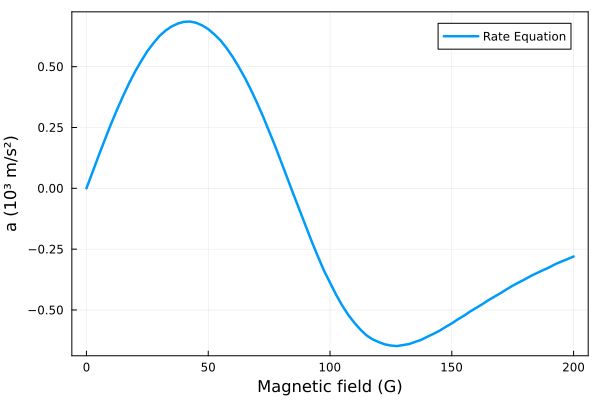

In [2158]:
plot(Bs./_μB, 1e-3 .* [f[3] for f in re_forces].* (ħ * k * Γ / m),
    xlabel="Magnetic field (G)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    label="Rate Equation"
    # labelfontsize=14,
    # tickfont=12,
    # legendfont=11,
    # ylim=(-3,23),
    # size=(600,500)
    )

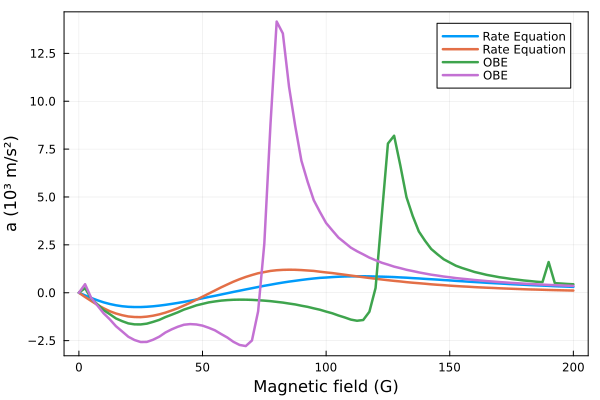

In [2065]:
plot!(Bs./_μB, 1e-3 .* averaged_forces .* (ħ * k * Γ / m),
    xlabel="Magnetic field (G)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    label="OBE",
    # labelfontsize=14,
    # tickfont=12,
    # legendfont=11,
    # ylim=(-3,23),
    # size=(600,500),
    dpi=100
    )

In [1867]:
savefig("C:\\Users\\halla\\Downloads\\lin_orthog_high_field.png")

"C:\\Users\\halla\\Downloads\\lin_orthog_high_field.png"

In [2146]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra,
    Revise,
StaticArrays
;

import MutableNamedTuples: MutableNamedTuple
import StructArrays: StructArray, StructVector
import StaticArrays: @SVector
import LinearAlgebra: norm, ⋅, adjoint!, diag
import LoopVectorization: @turbo

using Parameters

import ProgressMeter: Progress, next!



function N!(dN, N, rate_eq, τ)
    @unpack H,Hv, N0, N0_vec, ω, states, fields, r, v, Γ, λ, k, freq_res, d, R, v_prev, particle, extra_p= rate_eq
    if v_prev != v
        particle.v = v
        new_rate_eq = rate_equation(N0, particle, states, fields, d, d, true, true,λ, Γ, freq_res, extra_p)
        rate_eq.H = new_rate_eq.H
        rate_eq.Hv = new_rate_eq.Hv
        rate_eq.R = new_rate_eq.R
        rate_eq.v_prev = v
    end
    n_states = length(states)
    n_fields = length(fields)
    type_complex = ComplexF64
    n_l = extra_p.n_ground
    n_u = n_states - n_l
    n_fields = length(fields)
    

    dN[:] .= 0.0
    
    # update dN

    dN[1:n_states] += H * N[1:n_states]

    
    # update integrated population
    dN[n_states+1 : end-3] = N[1:n_states]

    
    row_of_1 = StructArray(ones(type_complex, 1,n_states))

    # update force
    for p in 1:1:n_fields
    dN[end-2:end] += fields[p].k * (row_of_1 * Hv[:,:,p] * N[1:n_states])[1]
    end

    return nothing
end


function rate_equation(N0, particle, states, fields, d, d_m, should_round_freqs, alway_true, λ=1.0, Γ=2π, freq_res=1e-2, extra_p=nothing)

    period = 2π / freq_res

    n_states = length(states)
    n_fields = length(fields)
    
    if n_fields > 0
        fields = StructArray(fields)
    end
    
     # calculate AC stark shift, manually add to states.
    H = extra_p.H
    H.parameters.s = sqrt(extra_p.s_orthog/2)
    H.parameters.T = -extra_p.Δ_orthog
#     H.parameters.s = 0.0
#     H.parameters.T = 1e12
    evaluate!(H)
    QuantumStates.solve!(H)
    
#     states = H.states
    
    proj_mapping = zeros(Int, length(H.states))
        
    states = deepcopy(states)
    states = StructArray(states)
    for i in 1:length(states)
       bare_proj = findmax(norm.(H.states[i].coeffs))[2]

        proj_mapping[i] = bare_proj
        states[i] = deepcopy(extra_p.bare_states[bare_proj])
        states.E[i] = H.states[i].E

        if bare_proj > extra_p.n_ground
           states.E[i] += extra_p.T + extra_p.Δ_orthog
        end
    end
    states = reorder_state_vector(states, proj_mapping)
    # reorder states to basis ordering
    
    k = 2π / λ

    # Convert to angular frequencies
    for i ∈ eachindex(fields)
        fields.ω[i] /= Γ
    end
    for i ∈ eachindex(states)
        states.E[i] *= 2π
        states.E[i] /= Γ
    end

    if should_round_freqs
        round_freqs!(states, fields, freq_res)
        particle.v = round_vel(particle.v, freq_res)
    end

    r0 = particle.r0
    r = particle.r
    v = particle.v
    v_prev = particle.v

    type_complex = ComplexF64


    ω = [state.E for state ∈ states]
    force_last_period = SVector(0.0, 0.0, 0.0)

    # matrix that updates populations:
    H = StructArray( zeros(type_complex, n_states, n_states) )
    n_l = extra_p.n_ground
    n_u = n_states - n_l
    n_fields = length(fields)

    # define R 
    R = StructArray(zeros(type_complex, n_l, n_u, n_fields))
    for p in 1:1:n_fields
        pol = fields[p].ϵ(0) #spherical
        # pol_cart = [(pol[1]-pol[3])/sqrt(2), (pol[1]+pol[3])/sqrt(2)*(-1im), pol[2]]
        for i in 1:1:n_l
            for j in 1:1:n_u
                ω_ij = energy(states[n_l + j]) - energy(states[i])
                ω_p = fields[p].ω
                doppler = fields[p].k ⋅ v
                f = -1 * pol[1]*d[i,n_l + j,1] + 1*pol[2]*d[i,n_l + j,2] - 1*pol[3]*d[i,n_l + j,3] 
                R[i,j,p] = 1/2 * real(f*conj(f)) * fields[p].s / (1 + 4*(ω_p - ω_ij - doppler)^2)
            end
        end
    end

    
    X = StructArray( zeros(type_complex, n_l, n_l, n_fields))
    for p in 1:1:n_fields
        for i in 1:1:n_l
            X[i,i,p] = sum(R[i,:,p])
        end
    end

    Y = StructArray(zeros(type_complex, n_u, n_u, n_fields))
    for p in 1:1:n_fields
        for j in 1:1:n_u
            Y[j,j,p] = sum(R[:,j,p])
        end
    end


    # define r (branching ratio of spontaneous decay)
    r = StructArray(zeros(type_complex, n_l, n_u))
    for i in 1:1:n_l 
        for j in 1:1:n_u 
            r[i,j] = norm(d[i,n_l + j,1])^2 + norm(d[i,n_l + j,2])^2 + norm(d[i,n_l + j,3])^2 
        end
    end

    # make sure population is conserved --- decay into lower = decay out from upper
    for j in 1:1:n_u
        r[:,j] = r[:,j]./ sum(r[:,j])
    end

    id_l = Matrix((1.0+0im)LinearAlgebra.I, n_l, n_l)
    id_u = Matrix((1.0+0im)LinearAlgebra.I, n_u, n_u)

    H = StructArray(zeros(type_complex, n_states, n_states))
    for p in 1:1:n_fields
        H[1:n_l, 1:n_l] += -X[:,:,p]
        H[1:n_l, n_l+1:n_states] += R[:,:,p]
        H[n_l+1: n_states, 1:n_l] += transpose(R[:,:,p])
        H[n_l+1: n_states, n_l+1: n_states] += -Y[:,:,p]
    end
    
    H[1:n_l, n_l+1:n_states] += r[:,:]
    H[n_l+1:n_states, n_l+1:n_states] += -id_u

    # update matrix for force
    Hv = StructArray(zeros(type_complex, n_states, n_states, n_fields))
    for p in 1:1:n_fields
        Hv[1:n_l, n_l+1:n_states, p] = -R[:,:,p]
        Hv[n_l+1:end, 1:n_l, p] = transpose(R[:,:,p])
    end

    N0_vec=[N0; N0; 0;0;0]
    populations = N0[:];

    p = MutableNamedTuple(
        H=H, Hv=Hv, particle=particle, N0=N0, N0_vec=N0_vec, ω=ω,
        states=states, fields=fields, r0=r0, r=r, v=v, Γ=Γ, λ=λ,
        period=period, k=k, freq_res=freq_res,
        force_last_period=force_last_period, 
        d=d, 
        extra_p=extra_p, R=R, populations= populations, v_prev=v)

    return p
end
function round_freqs!(states, fields, freq_res)
    """
    Rounds frequencies of state energies and fields by a common denominator.
    
    freq_res::Float: all frequencies are rounded by this value (in units of Γ)
    """
    for i in eachindex(fields)
        fields.ω[i] = round_freq(fields.ω[i], freq_res)
    end
    for i in eachindex(states)
        states.E[i] = round_freq(states.E[i], freq_res)
    end
    return nothing
end


function reset_force1!(integrator)
    force_current_period = integrator.u[end-2:end] / integrator.p.period
    force_diff = abs(norm(force_current_period) - norm(integrator.p.force_last_period))
    force_diff_rel = force_diff / norm(integrator.p.force_last_period)
    integrator.p.force_last_period = force_current_period
    
    n = length(integrator.p.states)
    integrator.p.populations .= integrator.u[n+1:end-3] / integrator.p.period

    force_reltol = 1e-4
    if (force_diff_rel < force_reltol) #|| (force_diff < 1e-6)
        terminate!(integrator)
    else
        integrator.u[end-2:end] .= 0.0
        integrator.u[n+1:end-3] .= 0.0
    end
    return nothing
end


function force_scan_v3(prob::T1, scan_values::T2, prob_func!::F1, output_func::F2; n_threads=Threads.nthreads()) where {T1,T2,F1,F2}

    n_values = reduce(*, size(scan_values))
    batch_size = fld(n_values, n_threads)
    remainder = n_values - batch_size * n_threads
    forces = Array{SVector{3, Float64}}(undef, n_values)
    populations = zeros(Float64, n_values, length(prob.p.states))

    prog_bar = Progress(n_values)

    Threads.@threads for i ∈ 1:n_threads
        prob_copy = deepcopy(prob)
        # Threads.@spawn begin
            # prob_func!(_prob, scan_values, i)
        force_cb = PeriodicCallback(reset_force1!, prob_copy.p.period)
        if :callback ∈ keys(prob_copy.kwargs)
            cbs = prob_copy.kwargs[:callback]
            prob_copy = remake(prob_copy, callback=CallbackSet(cbs, force_cb))
        else
            prob_copy = remake(prob_copy, callback=force_cb)
        end
        _batch_size = i <= remainder ? (batch_size + 1) : batch_size
        batch_start_idx = 1 + (i <= remainder ? (i - 1) : remainder) + batch_size * (i-1)
        for j ∈ batch_start_idx:(batch_start_idx + _batch_size - 1)
            prob_j = prob_func!(prob_copy, scan_values, j)
            sol = solve(prob_j, alg=DP5())
            forces[j] = output_func(prob_j.p, sol)
            prob_j.p.force_last_period = (0, 0, 0)

            populations[j,:] .= prob_j.p.populations

            next!(prog_bar)
        end
    end
    return forces, populations
end

force_scan_v3 (generic function with 1 method)

In [1700]:
# update the whole hamiltonian.
function remake_rate_equation_B(p, B)

    
    # Update magnetic field
    extra_p = deepcopy(p.extra_p)
    extra_p.H.parameters.B_z = B
    
    
    new_p = rate_equation(p.N0, p.particle, p.states, p.extra_p.lasers, p.d, p.d, true, true, p.λ, p.Γ, p.freq_res, extra_p)
    return new_p
end

remake_rate_equation_B (generic function with 1 method)

In [1489]:
N0 = [1.0,0,0,0,0,0]
freq_res = 1e-2
extra_p = MutableNamedTuple(H=deepcopy(H), lasers=lasers, n_ground=3, bare_states = deepcopy(bare_states), Δ_orthog=Δ_orthog, T=1e12, s_orthog=s_orthog)
particle.v = [0,0,1.0]

p = rate_equation(N0, particle, bare_states, lasers, d_bare, d_bare, true, true, λ, Γ, freq_res, extra_p)
energy.(p.states).*Γ/(2π)

6-element Vector{Float64}:
 6.208e6
 0.0
 6.208e6
 9.99993792e11
 1.0e12
 9.99993792e11

In [1490]:
p1 = remake_rate_equation_B(p, 0*_μB);
energy.(p1.states).*Γ/(2π)

6-element Vector{Float64}:
 6.208e6
 0.0
 6.208e6
 9.99993792e11
 1.0e12
 9.99993792e11

In [1491]:
display.(p1.states);

State{AngularMomentumState_Labelled}(0.97, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 1, (M = -1:1,))], ComplexF64[1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im], 1)

State{AngularMomentumState_Labelled}(0.0, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 1, (M = -1:1,))], ComplexF64[0.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im], 2)

State{AngularMomentumState_Labelled}(0.97, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 1, (M = -1:1,))], ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im], 3)

State{AngularMomentumState_Labelled}(156249.03, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 1, (M = -1:1,))], ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im], 4)

State{AngularMomentumState_Labelled}(156250.0, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 1, (M = -1:1,))], ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im], 5)

State{AngularMomentumState_Labelled}(156249.03, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 1, (M = -1:1,))], ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 1.0 + 0.0im], 6)

In [1492]:
norm.(p1.d[:,:,1])

6×6 Matrix{Float64}:
 0.0  0.0       0.0       0.0       0.0       0.0
 0.0  0.0       0.0       0.707107  0.0       0.0
 0.0  0.0       0.0       0.0       0.707107  0.0
 0.0  0.707107  0.0       0.0       0.0       0.0
 0.0  0.0       0.707107  0.0       0.0       0.0
 0.0  0.0       0.0       0.0       0.0       0.0

In [1493]:
H1 = deepcopy(p.extra_p.H)
H1.parameters.B_z = 5.0*_μB
p.extra_p.H = H1
n1 = rate_equation(p.N0, p.particle, states, p.extra_p.lasers, p.d, p.d, true, true, p.λ, p.Γ, p.freq_res, p.extra_p)
energy.(p.states).*Γ/(2π)

6-element Vector{Float64}:
 6.208e6
 0.0
 6.208e6
 9.99993792e11
 1.0e12
 9.99993792e11

In [1494]:
display.(p.states)

State{AngularMomentumState_Labelled}(0.97, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 1, (M = -1:1,))], ComplexF64[1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im], 1)

State{AngularMomentumState_Labelled}(0.0, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 1, (M = -1:1,))], ComplexF64[0.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im], 2)

State{AngularMomentumState_Labelled}(0.97, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 1, (M = -1:1,))], ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im], 3)

State{AngularMomentumState_Labelled}(156249.03, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 1, (M = -1:1,))], ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im], 4)

State{AngularMomentumState_Labelled}(156250.0, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 1, (M = -1:1,))], ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im], 5)

State{AngularMomentumState_Labelled}(156249.03, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 1, (M = -1:1,))], ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 1.0 + 0.0im], 6)

6-element Vector{Nothing}:
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing

In [1495]:
display.(reorder_state_vector(p.states, [1,3,2,5,4,6]))

State{AngularMomentumState_Labelled}(0.97, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 1, (M = -1:1,))], ComplexF64[1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im], 1)

State{AngularMomentumState_Labelled}(0.97, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 1, (M = -1:1,))], ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im], 3)

State{AngularMomentumState_Labelled}(0.0, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 1, (M = -1:1,))], ComplexF64[0.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im], 2)

State{AngularMomentumState_Labelled}(156250.0, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 1, (M = -1:1,))], ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im], 5)

State{AngularMomentumState_Labelled}(156249.03, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 1, (M = -1:1,))], ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im], 4)

State{AngularMomentumState_Labelled}(156249.03, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 1, (M = -1:1,))], ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 1.0 + 0.0im], 6)

6-element Vector{Nothing}:
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing

In [1496]:
display.(bare_states)

State{AngularMomentumState_Labelled}(0.0, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 1, (M = -1:1,))], ComplexF64[1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im], 1)

State{AngularMomentumState_Labelled}(0.0, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 1, (M = -1:1,))], ComplexF64[0.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im], 2)

State{AngularMomentumState_Labelled}(0.0, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 1, (M = -1:1,))], ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im], 3)

State{AngularMomentumState_Labelled}(1.0e12, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 1, (M = -1:1,))], ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im], 4)

State{AngularMomentumState_Labelled}(1.0e12, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 1, (M = -1:1,))], ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im], 5)

State{AngularMomentumState_Labelled}(1.0e12, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 1, (M = -1:1,))], ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 1.0 + 0.0im], 6)

6-element Vector{Nothing}:
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing